In [17]:
# Import packages
import os
import glob
import geopandas as gpd
import numpy as np
import pandas as pd
import gdal
import rasterio
from rasterio.mask import mask
import xarray
import rioxarray
import dask.array as da
from dask_rasterio import read_raster, write_raster 
import ee 
import descartes

In [2]:
# Set paths and host variables 
root = "Q:/Shared drives/"
project_dir = root + 'APHIS  Projects/eRADS'
data_dir = root + "/Data"
nass_dir = data_dir + '/Original/National_Agricultural_Statistics_Service_Data/'
cdl_dir = data_dir + '/Original/NASS/CDL/'

In [3]:
start_year = 2015
stop_year = 2020
cdl_years = list(range(start_year, stop_year + 1, 1))
cdl_yr = cdl_years[-1]
state = 'California'
county = 'Monterey'

#### rioxarray

In [6]:
cdl_path = cdl_dir + f"{cdl_yr}/{cdl_yr}_30m_cdls.img"
cdl_path

'Q:/Shared drives//Data/Original/NASS/CDL/2020/2020_30m_cdls.img'

In [7]:
with rasterio.open(cdl_path) as rast:
  cdl_crs = rast.crs
  print(cdl_crs)

PROJCS["Albers Conical Equal Area",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [9]:
counties_prj = counties.to_crs(cdl_crs)
counties_prj.crs

<Bound CRS: PROJCS["Albers Conical Equal Area",GEOGCS["NAD83", ...>
Name: Albers Conical Equal Area
Axis Info [cartesian]:
- [east]: Easting (meters)
- [north]: Northing (meters)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from NAD83 to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: Albers Conical Equal Area

In [10]:
# county_boundary = counties[(counties.STATE_NAME == state) & (counties.NAME == county)]
geom = (counties_prj.loc[(counties_prj['STATE_NAME'] == state) & (counties['NAME'] == county), 'geometry'])
geom

274    MULTIPOLYGON (((-2144485.974 1690108.121, -224...
Name: geometry, dtype: geometry

In [24]:
img = rioxarray.open_rasterio(
    cdl_path,
    parse_coordinates=True,
    chunks="auto",
).rio.clip(geom, from_disk=True)
img

<xarray.DataArray (band: 1, y: 5201, x: 4350)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * x            (x) float64 -2.275e+06 -2.275e+06 ... -2.144e+06 -2.144e+06
  * y            (y) float64 1.846e+06 1.846e+06 1.846e+06 ... 1.69e+06 1.69e+06
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    LAYER_TYPE:                 thematic
    OVERVIEWS_ALGORITHM:        IMAGINE Nearest Neighbor Resampling
    STATISTICS_EXCLUDEDVALUES:  0
    STATISTICS_HISTOBINVALUES:  0|419935673|61527236|14229809|31958929|380270...
    STATISTICS_HISTOMAX:        255
    STATISTICS_HISTOMIN:        0
    STATISTICS_HISTONUMBINS:    256
    STATISTICS_MAXIMUM:         254
    STATISTICS_MEAN:            128.24269752872
    STATISTICS_MEDIAN:          142
    STATISTICS_MINIMUM:         1
    STATISTICS_MODE:            152
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          56.064541991916
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1
    _FillValue:                 0

In [20]:
img.shape[1] * img.shape[2]

22624350

<AxesSubplot:>

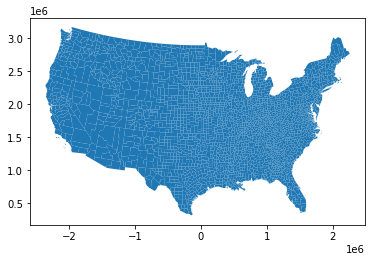

In [21]:
counties_prj.plot()

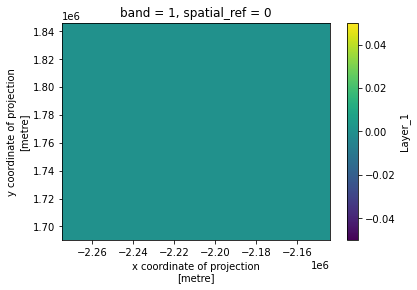

In [22]:
img.plot()

## Stacking

In [25]:
cdl_img_list = glob.glob(project_dir + "/data/cropLayer/*_cdls/*.img")
cdl_img_list

['Q:/Shared drives/APHIS  Projects/eRADS/data/cropLayer\\2015_30m_cdls\\2015_30m_cdls.img',
 'Q:/Shared drives/APHIS  Projects/eRADS/data/cropLayer\\2016_30m_cdls\\2016_30m_cdls.img',
 'Q:/Shared drives/APHIS  Projects/eRADS/data/cropLayer\\2017_30m_cdls\\2017_30m_cdls.img']

In [26]:
%%time
rast2arr = []
for i in range(0, len(cdl_img_list)):
    arr = rioxarray.open_rasterio(cdl_img_list[i], chunks={'band': 1, 'x': 1024, 'y': 1024}).astype(np.uint8)
    rast2arr.append(arr)

Wall time: 1.9 s


In [27]:
rast2arr[0]

,Array,Chunk
Bytes,13.83 GiB,1.00 MiB
Shape,"(1, 96523, 153811)","(1, 1024, 1024)"
Count,14346 Tasks,14345 Chunks
Type,uint8,numpy.ndarray


In [28]:
%%time
stack = da.stack(rast2arr).astype(np.uint8)

Wall time: 244 ms


In [29]:
stack

,Array,Chunk
Bytes,41.48 GiB,1.00 MiB
Shape,"(3, 1, 96523, 153811)","(1, 1, 1024, 1024)"
Count,86073 Tasks,43035 Chunks
Type,uint8,numpy.ndarray


In [30]:
def axis2char(row):
    char_val = '-'.join(str(i) for i in row)
    return char_val

In [31]:
%%time
charStack = da.apply_along_axis(axis2char, 0, stack)

Wall time: 617 ms


### rasterio

In [23]:
rast = rasterio.open(cdl_path)
rast.meta

{'driver': 'HFA',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 153811,
 'height': 96523,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["Albers Conical Equal Area",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(30.0, 0.0, -2356095.0,
        0.0, -30.0, 3172605.0)}

In [ ]:
src = rast.read(1)
src.shape

In [ ]:
src.max()

In [ ]:
df = pd.DataFrame(src.ravel())

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.columns=[f'crop_code']
df.head()

In [ ]:
with rasterio.open(cdl_path) as dataset:
    val = dataset.read(1) 
    no_data=dataset.nodata
    data = [(dataset.xy(x,y)[0],dataset.xy(x,y)[1],val[x,y]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    lon = [i[0] for i in data]
    lat = [i[1] for i in data]
    d = [i[2] for i in data]
    df = pd.DataFrame({"long":lon,'lat':lat,"crop_code":d})
df.head()